In [1]:
import SimpleITK as sitk
from ipywidgets import interact
from scipy import io
import numpy as np
import gui

print(sitk.Version())

SimpleITK Version: 2.1.1.2 (ITK 5.2)
Compiled: Apr 11 2022 23:40:09



In [2]:
# INPUT_FILENAME = "/home/rathoddinesh/Git Repos/Granular-Material-Packing-Analysis/Test Data/Steel_Deposition_181_176_251_downsampled.mhd"
INPUT_FILENAME = "/home/rathoddinesh/Downloads/Dry_Deposition.mat"

In [3]:
# image_viewer = sitk.ImageViewer()
# image_viewer.SetApplication('/home/rathoddinesh/Fiji.app/ImageJ-linux64')

In [3]:
file_ext = INPUT_FILENAME.split(".")[-1]
if file_ext == "mat":
    print("reading mat file")
    f = io.loadmat(INPUT_FILENAME)
    data = f.get('volm')
    npa = np.array(data)
elif file_ext == "mhd":
    print("reading raw file")
    file_reader = sitk.ImageFileReader()
    file_reader.SetFileName(INPUT_FILENAME)
    file_reader.SetImageIO('')
    image = file_reader.Execute()
    npa = sitk.GetArrayFromImage(image)
print("Original Shape : ", npa.shape)
# npa = np.transpose(npa, (2, 1, 0))
print("New Shape : ", npa.shape)
new_image = sitk.GetImageFromArray(npa)
# image_viewer.Execute(new_image)
print("reading done")

reading mat file
Original Shape :  (824, 804, 1004)
New Shape :  (824, 804, 1004)
reading done


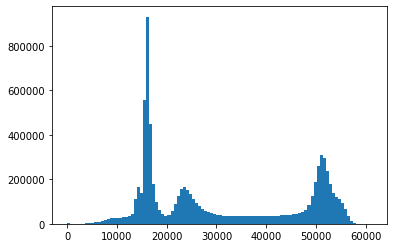

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure()
plt.hist(sitk.GetArrayViewFromImage(new_image).flatten(), bins=100)
plt.show()

In [6]:
# n_npa = (npa * 255.0)/npa.max()
# n_new_image = sitk.GetImageFromArray(n_npa)
# # image_viewer.Execute(n_new_image)
# # image_viewer.Execute(new_image)
# plt.figure()
# plt.hist(sitk.GetArrayViewFromImage(n_new_image).flatten(), bins=100)
# plt.show()

In [7]:
# new_image = n_new_image

In [8]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

thresholds = []

for k, v in threshold_filters.items():
    print(k + " Threshold Computed")
    v.Execute(new_image)
    thresholds.append(v.GetThreshold())
    print(thresholds[-1])

Otsu Threshold Computed
33907.140625
Triangle Threshold Computed
19221.255859375
Huang Threshold Computed
33190.79296875
MaxEntropy Threshold Computed
30204.830078125


In [9]:
def threshold_based_crop_and_bg_median(image):
    '''
    Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
    usually air. Then crop the image using the foreground's axis aligned bounding box and compute the background 
    median intensity.
    Args:
        image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                 (the assumption underlying Otsu's method.)
    Return:
        Cropped image based on foreground's axis aligned bounding box.
        Background median intensity value.
    '''
    # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
    # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
    inside_value = 0
    outside_value = 255
    bin_image = sitk.OtsuThreshold(image, inside_value, outside_value)

    # Get the median background intensity
    label_intensity_stats_filter = sitk.LabelIntensityStatisticsImageFilter()
    label_intensity_stats_filter.SetBackgroundValue(outside_value)
    label_intensity_stats_filter.Execute(bin_image,image)
    bg_median = label_intensity_stats_filter.GetMedian(inside_value)
    
    # Get the bounding box of the anatomy
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()    
    label_shape_filter.Execute(bin_image)
    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
    return bg_median, sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)]), bin_image

bg_medians, modified_data, bin_image = threshold_based_crop_and_bg_median(new_image)

In [10]:
print("Background Median intensity value : ", bg_medians)

# image_viewer.Execute(modified_data)
# image_viewer.Execute(new_image)
# image_viewer.Execute(bin_image)

Background Median intensity value :  16474.71875


<Figure size 432x288 with 0 Axes>

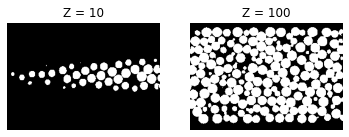

In [11]:
plt.figure()
# Display the image slice from the middle of the stack, z axis
Z = [10, 100]
f, axarr = plt.subplots(1, len(Z))
for i, z in enumerate(Z):
    axarr[i].imshow(sitk.GetArrayViewFromImage(bin_image)[z,:,:], cmap=plt.cm.Greys_r)
    axarr[i].set_title("Z = " + str(z))
    axarr[i].axis('off')

In [12]:
# gaussian = sitk.SmoothingRecursiveGaussianImageFilter()
# gaussian.SetSigma(1)
# g_image = gaussian.Execute(modified_data)

# bif = sitk.BilateralImageFilter()
# bif.SetDomainSigma(5.0)
# bif.SetRangeSigma(10.0)
# g_image = bif.Execute(modified_data)
# plt.figure()
# # Display the image slice from the middle of the stack, z axis
# f, axarr = plt.subplots(1, 2)
# slice_no = 100
# axarr[0].imshow(sitk.GetArrayViewFromImage(modified_data)[slice_no,:,:], cmap=plt.cm.Greys_r)
# axarr[0].set_title("Z = " + str(0))
# axarr[0].axis('off')
# axarr[1].imshow(sitk.GetArrayViewFromImage(g_image)[slice_no,:,:], cmap=plt.cm.Greys_r)
# axarr[1].set_title("Z = " + str(1))
# axarr[1].axis('off')

# modified_data = g_image

Using Threshold :  33907.140625
Total points :  6627903
Total Inside points :  3188792
Max Val :  61123.59375


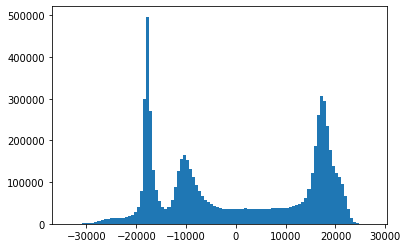

In [13]:
print("Using Threshold : ", thresholds[0])
dist_image_arr = sitk.GetArrayFromImage(modified_data) - thresholds[0]
dist_image = sitk.GetImageFromArray(dist_image_arr)

npa = sitk.GetArrayFromImage(modified_data)

total_num_points = (npa > 0).sum()
inside_num_points = (npa > thresholds[0]).sum()
max_dens_val = np.max(npa)
print("Total points : ", total_num_points)
print("Total Inside points : ", inside_num_points)
print("Max Val : ", max_dens_val)
plt.figure()
plt.hist(sitk.GetArrayViewFromImage(dist_image).flatten(), bins=100)
plt.show()

In [14]:
# image_viewer.Execute(modified_data)
# image_viewer.Execute(new_image)

In [15]:
lambda_1 = total_num_points * max_dens_val / (inside_num_points * (max_dens_val - thresholds[0]))
lambda_2 = total_num_points * max_dens_val / ((total_num_points - inside_num_points) * (thresholds[0]))

In [16]:
from skimage.segmentation import morphological_chan_vese
print('Commencing Chan and  Vese with Lambda 1 and Lambda 2 as follows:')
print("Lambda 1 : ", lambda_1)
print("Lambda 2 : ", lambda_2)
ls = morphological_chan_vese(npa, 20, init_level_set=dist_image_arr, lambda1=abs(lambda_1),lambda2=abs(lambda_2),smoothing=0)
print('Boundary Extracted.')

Commencing Chan and  Vese with Lambda 1 and Lambda 2 as follows:
Lambda 1 :  4.667961933198245
Lambda 2 :  3.474142785329728
Boundary Extracted.


In [17]:
import itk

print('Commencing Distance Field Computation')
itk_image = itk.GetImageFromArray(np.array(ls).astype(np.float32))

antialiasfilter = itk.AntiAliasBinaryImageFilter.New(itk_image)
antialiasfilter.SetInput(itk_image)
antialiasfilter.SetMaximumRMSError(0.01)
antialiasfilter.SetNumberOfIterations(30)
antialiasfilter.Update()
antialias_image = antialiasfilter.GetOutput()

isoContourFilter = itk.IsoContourDistanceImageFilter.New(antialias_image)
isoContourFilter.SetLevelSetValue(0.5)
isoContourFilter.SetFarValue(1000) #make sure this is greater than your max distance value for the chamfer filter
isoContourFilter.SetInput(antialias_image)
isoContourFilter.Update()
isoContour_image = isoContourFilter.GetOutput()

chamferFilter = itk.FastChamferDistanceImageFilter.New(isoContour_image)
chamferFilter.SetMaximumDistance(50.0)
chamferFilter.Update()
chamferFilter.SetInput(isoContour_image)
chamferFilter.Update()
chamf_image = chamferFilter.GetOutput()
chamf_arr = itk.GetArrayFromImage(chamf_image)
dist_image = sitk.GetImageFromArray(chamf_arr)
print('Distance Field Computed')

Commencing Distance Field Computation
Distance Field Computed


In [18]:
import os

print('Writing File')

raw_writer = sitk.ImageFileWriter()
output_path_name = 'Outputs/'

if not os.path.exists(output_path_name):
    os.makedirs(output_path_name)

raw_writer.SetFileName(output_path_name + 'chamf_distance_Steel_2' + '.mhd')
raw_writer.Execute(dist_image)

print('File Written')

Writing File
File Written
